In [17]:
pip install prophet

   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.1 MB 1.5 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/12.1 MB 1.5 MB/s eta 0:00:08
   ---- ----------------------------------- 1.3/12.1 MB 1.7 MB/s eta 0:00:07
   ----- ---------------------------------- 1.6/12.1 MB 1.8 MB/s eta 0:00:06
   ------ --------------------------------- 2.1/12.1 MB 1.8 MB/s eta 0:00:06
   -------- ------------------------------- 2.6/12.1 MB 1.9 MB/s eta 0:00:06
   --------- ------------------------------ 2.9/12.1 MB 1.9 MB/s eta 0:00:05
   ---------- ----------------------------- 3.1/12.1 MB 1.8 MB/s eta 0:00:06
   ----------- ---------------------------- 3.4/12.1 MB 1.8 MB/s eta 0:00:05
   ------------ --------------------------- 3.7/12.1 MB 1.7 MB/s eta 0:00:05
   ------------ --------------------------- 3.9/12.1 MB 1.7 MB/s eta 0:00:05
   ----------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


LOAD DỮ LIỆU

In [4]:
df = pd.read_csv("train.csv")
print(f"Data shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

Data shape: (1460, 81)
Columns: 81


KIỂM TRA DỮ LIỆU BAN ĐẦU

In [21]:
# Train/Test split theo năm
df_train = df[df['YrSold'] < 2010].copy()
df_test  = df[df['YrSold'] >= 2010].copy()

# Xử lý giá trị thiếu
def basic_impute(df_in):
    df = df_in.copy()

    for c in df.select_dtypes(include=np.number):
        df[c] = df[c].fillna(df[c].median())

    for c in df.select_dtypes(include=["object", "category"]):
        df[c] = df[c].fillna(df[c].mode().iloc[0] if not df[c].mode().empty else "NA")

    return df

def print_strategy_summary(name, train_df, test_df, n_preview=5):
    print(f"{name.upper()} RESULTS")
    print(f"Train shape : {train_df.shape}")
    print(f"Test shape  : {test_df.shape}")
    print(f"Features    : {train_df.shape[1] - 1}")
    assert list(train_df.columns) == list(test_df.columns), "Column mismatch!"

quality_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, np.nan: 0}

location_lot_cols = [
    "MSSubClass", "MSZoning", "LotFrontage", "LotArea",
    "Street", "Alley", "LotShape", "LandContour",
    "Utilities", "LotConfig", "LandSlope",
    "Neighborhood", "Condition1", "Condition2"
]

size_interior_cols = [
    "GrLivArea", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF",
    "LowQualFinSF", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",
    "TotRmsAbvGrd", "BedroomAbvGr", "KitchenAbvGr",
    "GarageArea", "GarageCars", "MasVnrArea"
]

quality_condition_cols = [
    "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd",
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond",
    "HeatingQC", "KitchenQual", "FireplaceQu",
    "GarageQual", "GarageCond", "PoolQC"
]

amenities_cols = [
    "Fireplaces", "GarageYrBlt", "PoolArea", "Fence",
    "MiscVal"
]

groups_info = {
    "Location & Lot": location_lot_cols,
    "Size & Interior": size_interior_cols,
    "Quality & Condition": quality_condition_cols,
    "Amenities": amenities_cols
}

print(f"Train: {len(df_train)} rows ({len(df_train)/len(df)*100:.1f}%)")
print(f"Test:  {len(df_test)} rows ({len(df_test)/len(df)*100:.1f}%)")
print(f"\nTrain years: {df_train['YrSold'].min()} - {df_train['YrSold'].max()}")
print(f"Test years:  {df_test['YrSold'].min()} - {df_test['YrSold'].max()}")
print("\nFeature groups loaded:")
print(f"Location & Lot:     {len(location_lot_cols)}")
print(f"Size & Interior:    {len(size_interior_cols)}")
print(f"Quality & Condition:{len(quality_condition_cols)}")
print(f"Amenities/Sale:     {len(amenities_cols)}")

Train: 1285 rows (88.0%)
Test:  175 rows (12.0%)

Train years: 2006 - 2009
Test years:  2010 - 2010

Feature groups loaded:
Location & Lot:     14
Size & Interior:    14
Quality & Condition:14
Amenities/Sale:     5


LỰA CHỌN ĐẶC TRƯNG CỦA MỖI NHÓM

=== KẾT QUẢ TUYỂN CHỌN ĐẠI BIỂU CHO 4 NHÓM ===
NHÓM                           | ĐẠI BIỂU ĐƯỢC CHỌN   | ĐỘ TƯƠNG QUAN  
---------------------------------------------------------------------------
1. Location & Lot              | LotFrontage          | 0.3518
2. Size & Interior             | GrLivArea            | 0.7086
3. Quality & Condition         | OverallQual          | 0.7910
4. Amenities                   | GarageCars           | 0.6404
---------------------------------------------------------------------------
-> Danh sách các cột sẽ đưa vào Prophet: ['LotFrontage', 'GrLivArea', 'OverallQual', 'GarageCars']


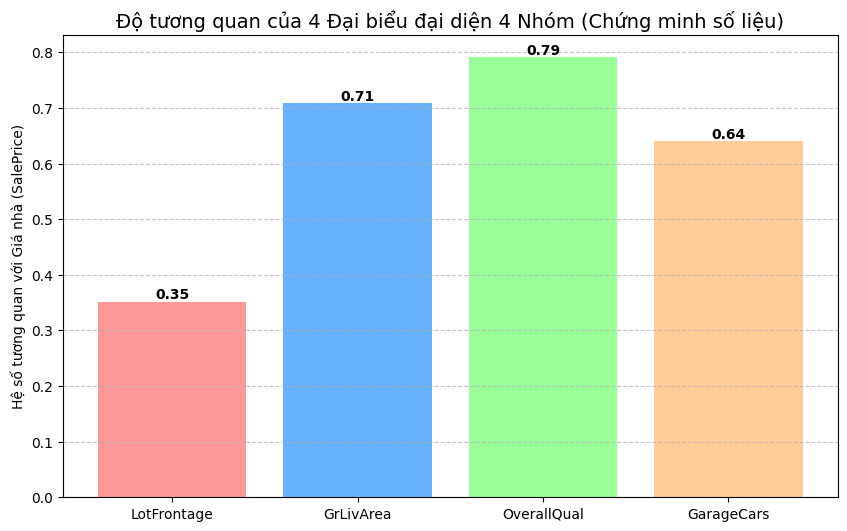

In [22]:
df = pd.read_csv('train.csv')
numeric_df = df.select_dtypes(include=[np.number])

# 2. Tính tương quan với SalePrice
correlations = numeric_df.corr()['SalePrice'].sort_values(ascending=False)

teacher_groups = {
    "1. Location & Lot": [
    "MSSubClass", "MSZoning", "LotFrontage", "LotArea",
    "Street", "Alley", "LotShape", "LandContour",
    "Utilities", "LotConfig", "LandSlope",
    "Neighborhood", "Condition1", "Condition2"
], 
    "2. Size & Interior": [
    "GrLivArea", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF",
    "LowQualFinSF", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",
    "TotRmsAbvGrd", "BedroomAbvGr", "KitchenAbvGr",
    "GarageArea", "GarageCars", "MasVnrArea"
]
,
    "3. Quality & Condition": [
    "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd",
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond",
    "HeatingQC", "KitchenQual", "FireplaceQu",
    "GarageQual", "GarageCond", "PoolQC"
],

    "4. Amenities": ['GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea']
}

print("=== KẾT QUẢ TUYỂN CHỌN ĐẠI BIỂU CHO 4 NHÓM ===")
print(f"{'NHÓM':<30} | {'ĐẠI BIỂU ĐƯỢC CHỌN':<20} | {'ĐỘ TƯƠNG QUAN':<15}")
print("-" * 75)

final_features = []

for group_name, candidates in teacher_groups.items():
    valid_candidates = [c for c in candidates if c in correlations.index]
    
    if valid_candidates:
        best_feature = correlations[valid_candidates].idxmax()
        score = correlations[best_feature]
        
        print(f"{group_name:<30} | {best_feature:<20} | {score:.4f}")
        final_features.append(best_feature)
    else:
        print(f"{group_name:<30} | Không có ứng viên số | N/A")

print("-" * 75)
print(f"-> Danh sách các cột sẽ đưa vào Prophet: {final_features}")

selected_corr = correlations[final_features]

plt.figure(figsize=(10, 6))
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'] 
bars = plt.bar(selected_corr.index, selected_corr.values, color=colors)

plt.title('Độ tương quan của 4 Đại biểu đại diện 4 Nhóm (Chứng minh số liệu)', fontsize=14)
plt.ylabel('Hệ số tương quan với Giá nhà (SalePrice)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontweight='bold')

plt.show()

KHỞI TẠO DATASET

Đã xuất file thành công: prophet_ready_data.csv


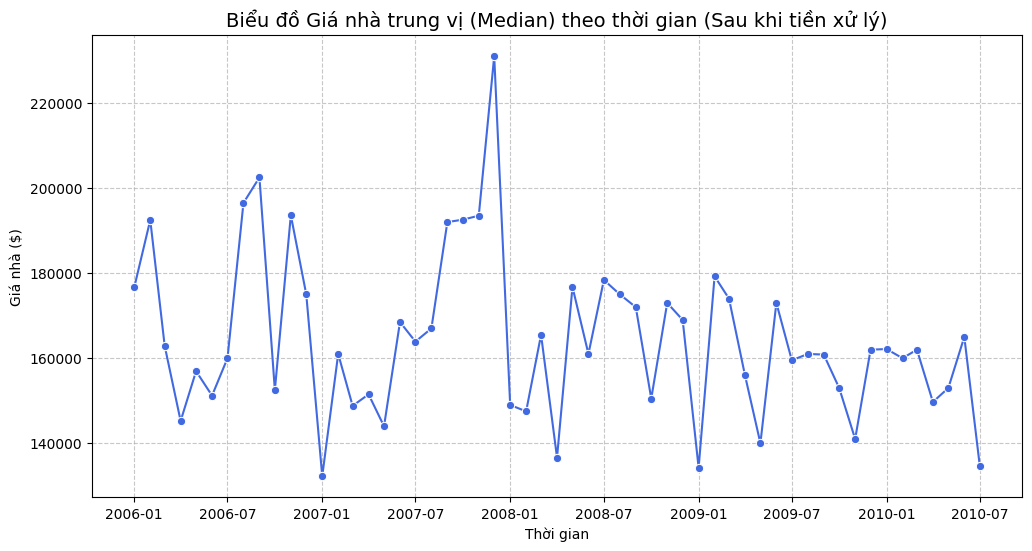

          ds         y       LotArea    GrLivArea  OverallQual  GarageCars
0 2006-01-01  176700.0  15001.900000  1517.500000     6.000000    2.200000
1 2006-02-01  192500.0  10559.777778  1758.555556     6.777778    2.222222
2 2006-03-01  162900.0  10202.480000  1558.440000     6.360000    1.760000
3 2006-04-01  145250.0   8340.703704  1541.777778     6.259259    1.666667
4 2006-05-01  156950.0   9445.657895  1365.605263     5.605263    1.763158


In [24]:
def create_prophet_dataset(file_path):
    df = pd.read_csv(file_path)
    df['ds'] = pd.to_datetime(df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str) + '-01')

    selected_cols = ['ds', 'SalePrice', 'LotArea', 'GrLivArea', 'OverallQual', 'GarageCars']
    df_slim = df[selected_cols].copy()

    df_ts = df_slim.groupby('ds').agg({
        'SalePrice': 'median',       # Target y (Median)
        'LotArea': 'mean',           # Regressor 1 (Mean)
        'GrLivArea': 'mean',         # Regressor 2 (Mean)
        'OverallQual': 'mean',       # Regressor 3 (Mean)
        'GarageCars': 'mean'         # Regressor 4 (Mean)
    }).reset_index()

    full_range = pd.date_range(start=df_ts['ds'].min(), end=df_ts['ds'].max(), freq='MS')
    df_ts = df_ts.set_index('ds').reindex(full_range)
    df_ts = df_ts.interpolate(method='linear')
    
    df_ts = df_ts.reset_index().rename(columns={'index': 'ds', 'SalePrice': 'y'})

    return df_ts

# --- THỰC THI VÀ XUẤT FILE ---
df_prophet = create_prophet_dataset('train.csv')

output_filename = 'prophet_ready_data.csv'
df_prophet.to_csv(output_filename, index=False)
print(f"Đã xuất file thành công: {output_filename}")

# VẼ BIỂU ĐỒ KIỂM TRA ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_prophet, x='ds', y='y', marker='o', color='royalblue')
plt.title('Biểu đồ Giá nhà trung vị (Median) theo thời gian (Sau khi tiền xử lý)', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Giá nhà ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(df_prophet.head())

CHIA TẬP DỮ LIỆU (CHE ĐI KẾT QUẢ CỦA NĂM 2010)

In [26]:

split_date = '2010-01-01'

train_ts = df_prophet[df_prophet['ds'] < split_date].copy()

test_ts = df_prophet[df_prophet['ds'] >= split_date].copy()

print(f"Tổng số tháng dữ liệu: {len(df_prophet)}")
print(f"--> Số tháng dùng để học (Train): {len(train_ts)} (2006-2009)")
print(f"--> Số tháng dùng để thi (Test) : {len(test_ts)} (Năm 2010 - Đã bị che)")

m = Prophet(seasonality_mode='multiplicative') 

m.add_regressor('LotArea')      # Đại diện nhóm 1
m.add_regressor('GrLivArea')    # Đại diện nhóm 2
m.add_regressor('OverallQual')  # Đại diện nhóm 3
m.add_regressor('GarageCars')   # Đại diện nhóm 4

print("\nĐang huấn luyện mô hình...")
m.fit(train_ts)
print("-> Đã học xong quy luật từ 2006-2009!")



future = test_ts.drop(columns=['y']) 

forecast = m.predict(future)


# Lấy đáp án thật (y) và đáp án máy đoán (yhat)
y_true = test_ts['y'].values
y_pred = forecast['yhat'].values

# Tính sai số MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)

print("\n" + "="*40)
print(f"KẾT QUẢ TEST (NĂM 2010))")
print("="*40)
print(f"Sai số tuyệt đối trung bình (MAE): ${mae:,.0f}")
print(f"Sai số phần trăm (MAPE): {mape:.2f}%")

if mape < 10:
    print("-> Đánh giá: XUẤT SẮC (Sai số dưới 10%)")
elif mape < 20:
    print("-> Đánh giá: CHẤP NHẬN ĐƯỢC")
else:
    print("-> Đánh giá: CẦN CẢI THIỆN")

comparison_df = pd.DataFrame({
    'Tháng': test_ts['ds'].dt.strftime('%Y-%m'),
    'Thực tế': y_true,
    'Dự báo': y_pred,
    'Lệch ($)': y_pred - y_true,
    'Lệch (%)': ((y_pred - y_true)/y_true)*100
})
print("\nChi tiết dự báo từng tháng:")
print(comparison_df)

13:15:31 - cmdstanpy - INFO - Chain [1] start processing


Tổng số tháng dữ liệu: 55
--> Số tháng dùng để học (Train): 48 (2006-2009)
--> Số tháng dùng để thi (Test) : 7 (Năm 2010 - Đã bị che)

Đang huấn luyện mô hình...


13:15:31 - cmdstanpy - INFO - Chain [1] done processing


-> Đã học xong quy luật từ 2006-2009!

KẾT QUẢ TEST (NĂM 2010))
Sai số tuyệt đối trung bình (MAE): $10,340
Sai số phần trăm (MAPE): 6.68%
-> Đánh giá: XUẤT SẮC (Sai số dưới 10%)

Chi tiết dự báo từng tháng:
      Tháng   Thực tế         Dự báo      Lệch ($)   Lệch (%)
48  2010-01  162150.0  134315.378831 -27834.621169 -17.165971
49  2010-02  160000.0  142179.785574 -17820.214426 -11.137634
50  2010-03  162000.0  161027.246725   -972.753275  -0.600465
51  2010-04  149700.0  144236.278979  -5463.721021  -3.649780
52  2010-05  153000.0  149829.096811  -3170.903189  -2.072486
53  2010-06  165000.0  160968.894138  -4031.105862  -2.443094
54  2010-07  134750.0  121666.764960 -13083.235040  -9.709265
